<a href="https://colab.research.google.com/github/AusteKan/ML_AI/blob/main/ML_workflows/Functional_API_example_Wide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
An example of building a wide and deep functional DN using the California housing dataset.
This example can be extended and integrated into other workflows.

The goal is to demonstrate several approaches towards developing DN models. Such an exploratory analysis should
later be used to build appropriate ML/DL models.

Finally, testing various DN configurations can lead to a better understanding of the most important data features.

NOTE this is an example of architecture's exploration. Active models should be built and packaged following MLops principles.
"""

"\nAn example of building a wide functional DN using California housing dataset.\nThis example can be extended and integrated into other workflows.\n\nNOTE this is an example of architecture's exploration. Active models should be built and package following MLops principles.\n"

In [18]:
#Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D,GlobalAveragePooling1D

In [3]:
#Helper functions

def model_eval(history,epochs):

  """
  A regression model evaluation using history and epoch parameters

  #Arguments 
    history (keras obj) - keras history object
    epochs  (keras obj) - keras epcohs object
  #Returns
    training an dvalidation plots for a regression analysis
  """
  #NOTE due to train and validation set calculation specifics epochs need to be shifted
  plt.plot(range(len(epochs)),history['mean_squared_error'],'b-',label="Train MSE")
  plt.plot(np.arange(0.5,len(epochs)+0.5),history['val_mean_squared_error'],'r-',label="Validation MSE")
  plt.show()

  plt.plot(range(len(epochs)),history['mean_absolute_error'],'b-',label="Train MAE")
  plt.plot(np.arange(0.5,len(epochs)+0.5),history['val_mean_absolute_error'],'r-',label="Validation MAE")
  plt.show()
  return

In [4]:
#Get data

data_cal=fetch_california_housing()

data=pd.DataFrame(data_cal.data,columns=data_cal.feature_names)
target=data_cal.target

In [5]:
#Explore data 
#NOTE this is a very high level look at the data
#you should generally build custome EDA functions and/or packages for consistent data exploration

print(data.head(),"\n")
print(data.describe(),"\n")
print("Missing values",data.isnull().sum(),"\n")
print("Duplicated values",data.duplicated().sum(),"\n")

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25   

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.0

In [6]:
#Data consistency checks should be used via specialised functions for routine analytical tasks
target_df=pd.DataFrame(target,columns=["Target"])
print(target_df.head(),"\n")
print(target_df.describe(),"\n")
print("Missing values",target_df.isnull().sum(),"\n")
print("Duplicated values",target_df.duplicated().sum(),"\n")
print("An example of duplicated values",target_df[target_df.duplicated()][1:10])

   Target
0   4.526
1   3.585
2   3.521
3   3.413
4   3.422 

             Target
count  20640.000000
mean       2.068558
std        1.153956
min        0.149990
25%        1.196000
50%        1.797000
75%        2.647250
max        5.000010 

Missing values Target    0
dtype: int64 

Duplicated values 16798 

An example of duplicated values     Target
56   0.875
72   0.750
74   1.375
78   1.125
81   1.125
82   1.125
83   1.375
84   1.188
86   1.188


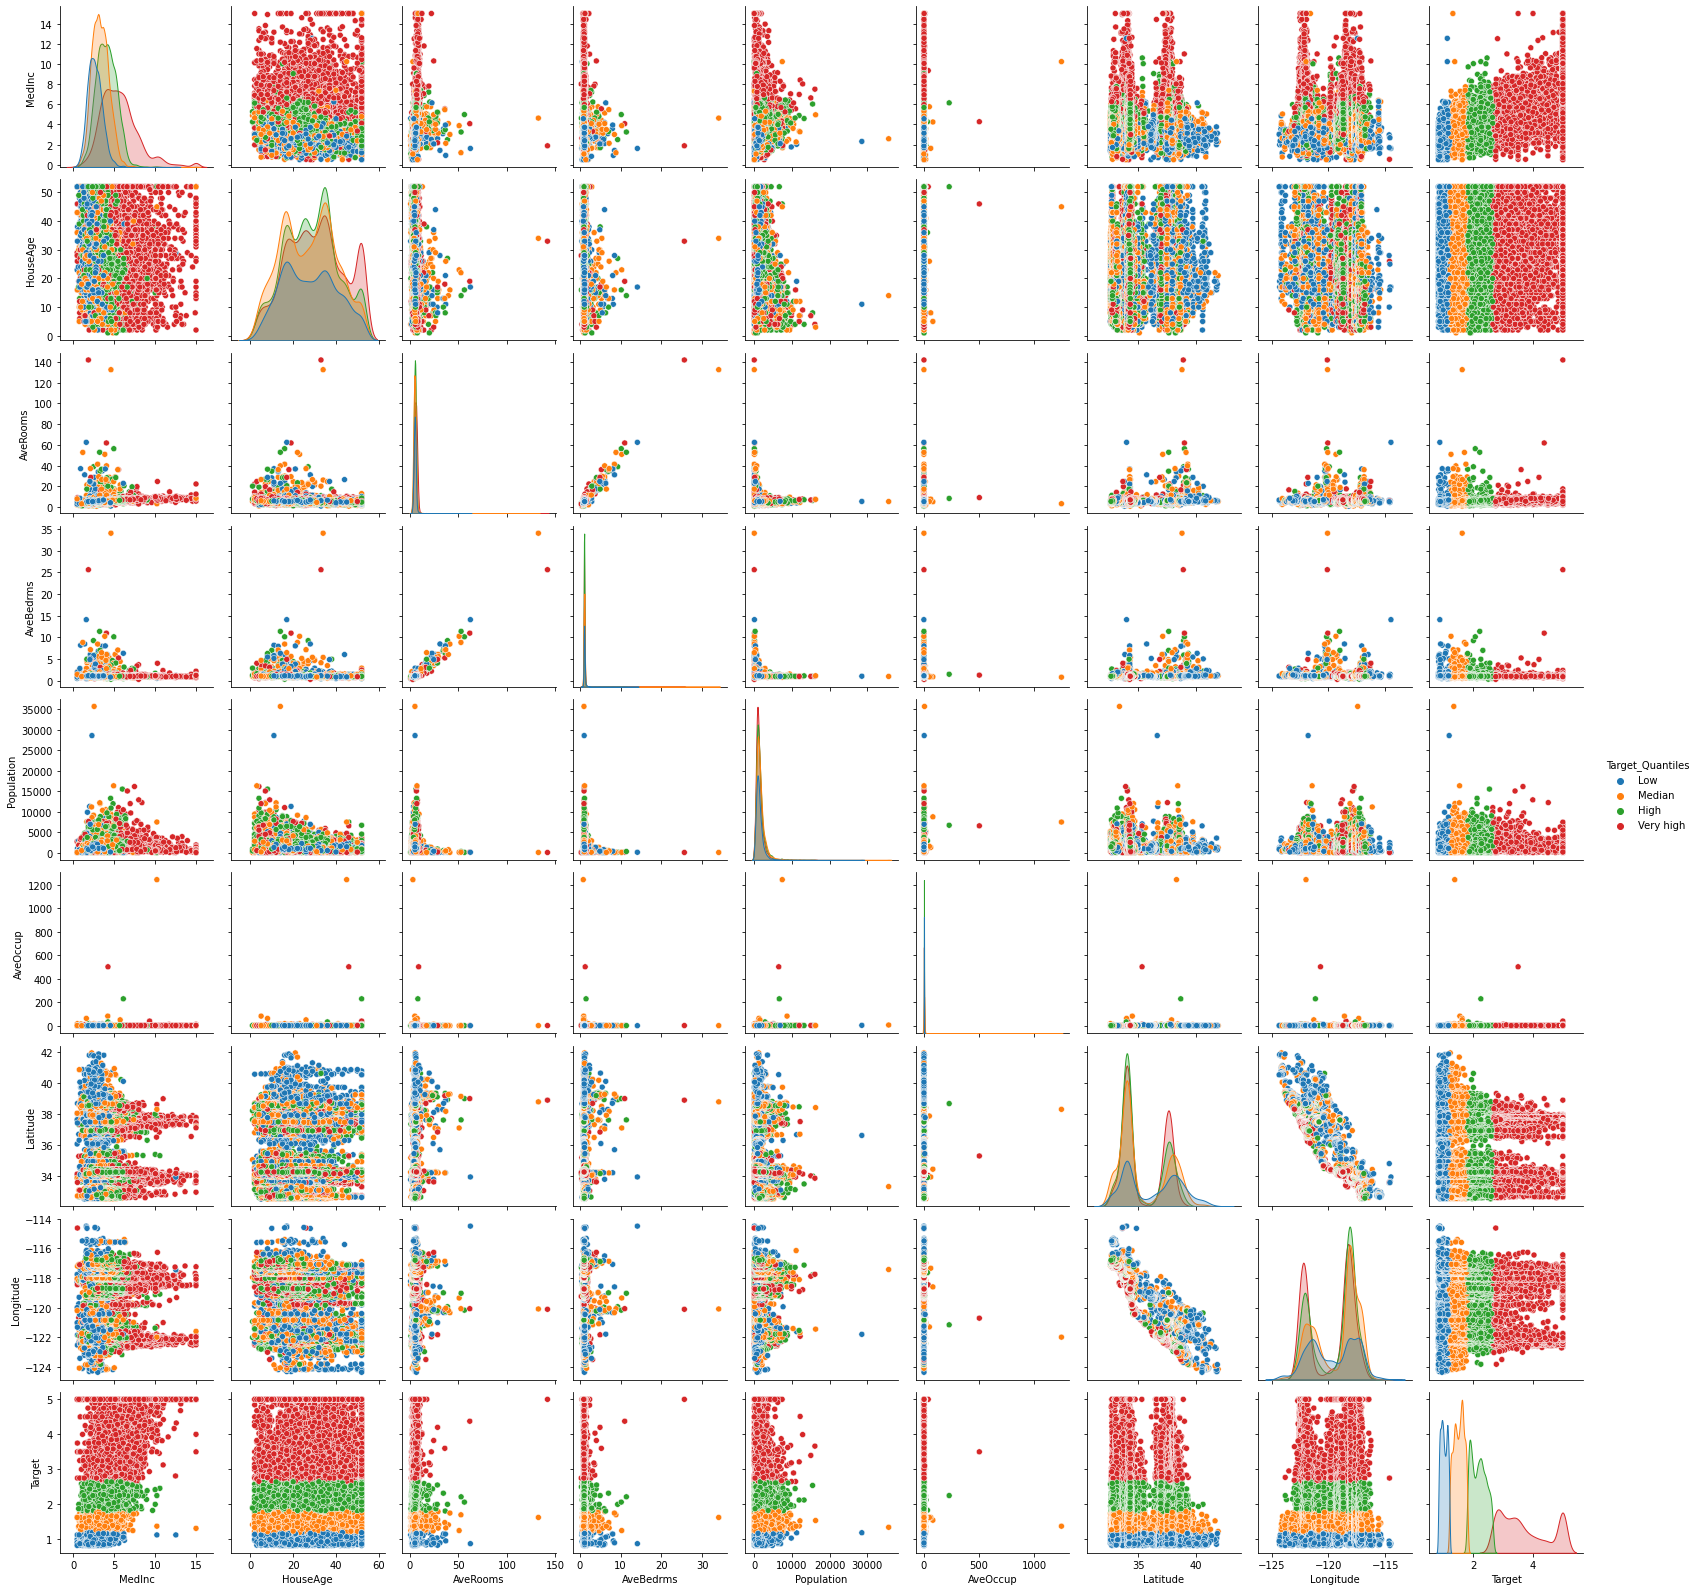

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


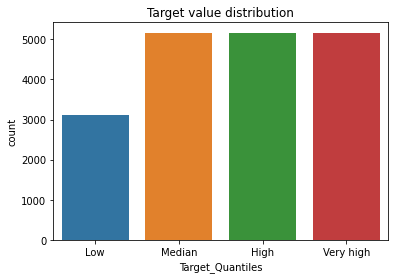

In [6]:
#Explore correlations
df=pd.concat([data,target_df],ignore_index=True,axis=1)
df.columns=data.columns.tolist()+target_df.columns.tolist()

#Add qualitative assessment for plots
#NOTE it is a good idea to include additional features during exploration
#this can help uncover various dependencies and relevant data points for the downstream analysis
#NOTE any feature or combination can be assessed in this way
df['Target_Quantiles']=pd.qcut(df['Target'],q=[0.1,0.25,0.5,0.75,1],labels=["Low","Median","High","Very high"])
df.head()

sns.pairplot(df,hue='Target_Quantiles',diag_kind='kde')
plt.show()

sns.countplot(df['Target_Quantiles'])
plt.title("Target value distribution")
plt.show()

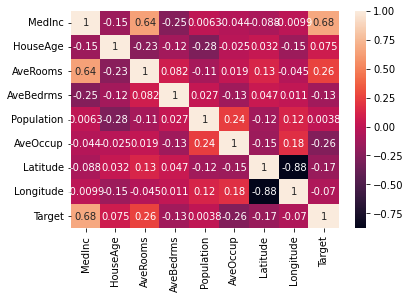

In [ ]:
sns.heatmap(df.corr(method='spearman'),annot=True)
plt.show()

In [7]:
#Drop values that don't contribute
#NOTE this is an iterative process and there are additional tests you should perform
#to assess correlation effects across features
#data.drop(columns=['Latitude','Longitude'],inplace=True)
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [8]:
#Split data
X_train,X_test,y_train,y_test=train_test_split(data,target,test_size=0.2,random_state=0)

#Scale data
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [44]:
#Set params

EPOCHS=100
BATCH=128
VAL_SPLIT=0.2
INPUT_SHAPE=X_train.shape[1:]
callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,min_delta=1)

In [ ]:
#Create a baseline regression model

def base_model(units=32,input_shape=INPUT_SHAPE):
  """
  A simple model builder to establish a baseline regression 
  #NOTE several baseline models can be used to better assess target model performance
  
  #Arguments
  units, int - dense layer units
  input_shape, tuple(int) - input shape (None, Features)

  #Returns
  model (keras obj)
  """
  model=Sequential()

  model.add(Dense(units,activation='relu',input_shape=input_shape))
  model.add(Dense(1))

  model.summary()
  model.compile(loss="mean_squared_error",optimizer='adam',metrics=['mean_squared_error','mean_absolute_error'])

  return model

In [ ]:
#Create a baseline regression model

def base_model_2(units=32, dropout=0.2,input_shape=INPUT_SHAPE):
  """
  A simple model builder for two hidden layers
  
  #Arguments
  units, int - dense layer units
  input_shape, tuple(int) - input shape (None, Features)
  dropout, float - dropout value

  #Returns
  model (keras obj)
  """
  model=Sequential()

  model.add(Dense(units*2,activation='relu',input_shape=input_shape))
  model.add(Dropout(dropout))
  model.add(Dense(units,activation='relu'))
  model.add(Dropout(dropout))
  
  if units//2>10:
    model.add(Dense(units//2,activation='relu'))
  
  model.add(Dense(1))

  model.summary()
  model.compile(loss="mean_squared_error",optimizer='adam',metrics=['mean_squared_error','mean_absolute_error'])

  return model

In [ ]:
#Fit base model
base_model1=base_model(128)
history=base_model1.fit(X_train,y_train,batch_size=BATCH,epochs=EPOCHS,validation_split=VAL_SPLIT,callbacks=[callbacks])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               1152      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
104/104 [==============================] - 1s 4ms/step - loss: 2.1416 - mean_squared_error: 2.1416 - mean_absolute_error: 1.0626 - val_loss: 0.8341 - val_mean_squared_error: 0.8341 - val_mean_absolute_error: 0.6783
Epoch 2/100
104/104 [==============================] - 0s 3ms/step - loss: 0.7331 - mean_squared_error: 0.7331 - mean_absolute_error: 0.6167 - val_loss: 0.6227 - val_mean_squared_error: 0.6227 - val_mean_absolute_error: 0

In [ ]:
epochs=history.epoch
history=history.history
BEST_EPOCH=np.argmin(history['val_loss'])
print("Best epoch", np.argmin(history['val_loss']))

Best epoch 44


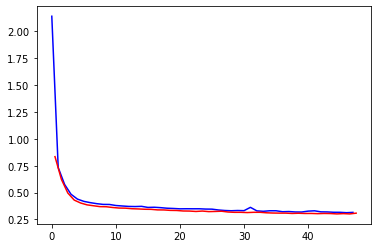

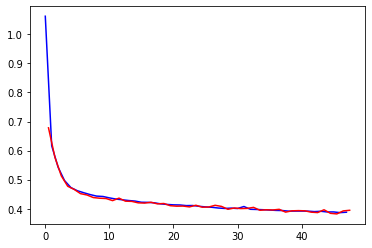

In [ ]:
model_eval(history,epochs)

In [ ]:
#Retrain the model
#Alternatively you can use ModelCheckpoints (this should be done for typical ML dev tasks)
base_model1=base_model(128)
history=base_model1.fit(X_train,y_train,batch_size=BATCH,epochs=BEST_EPOCH)
epochs=history.epoch
history=history.history



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               1152      
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/44
129/129 [==============================] - 1s 2ms/step - loss: 1.9602 - mean_squared_error: 1.9602 - mean_absolute_error: 1.0026
Epoch 2/44
129/129 [==============================] - 0s 2ms/step - loss: 0.6397 - mean_squared_error: 0.6397 - mean_absolute_error: 0.5804
Epoch 3/44
129/129 [==============================] - 0s 2ms/step - loss: 0.4983 - mean_squared_error: 0.4983 - mean_absolute_error: 0.5063
Epoch 4/44
129/129 [========

In [ ]:
#Evaluate model
base_model1.evaluate(X_test,y_test)

y_pred=base_model1.predict(X_test)

print("R2 model evaluation",r2_score(y_test,y_pred))

129/129 [==============================] - 1s 4ms/step - loss: 0.3128 - mean_squared_error: 0.3128 - mean_absolute_error: 0.3936
R2 model evaluation 0.687784490921244


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               4608      
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 168,961
Trainable params: 168,961
Non-tr

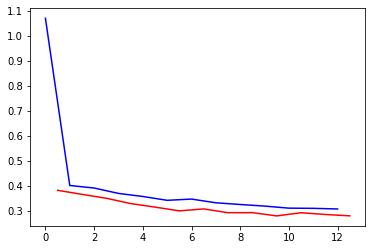

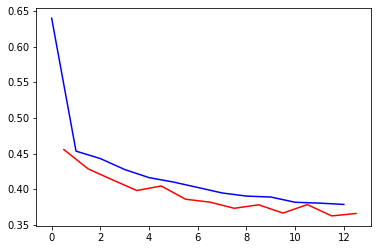

129/129 [==============================] - 0s 2ms/step - loss: 0.2880 - mean_squared_error: 0.2880 - mean_absolute_error: 0.3672
R2 model evaluation 0.7290949904017515


In [ ]:
#Fit base model 2
#define MolecChekpoints

mcp=tf.keras.callbacks.ModelCheckpoint("best_basemodel2.h5",monitor="mean_squared_error",verbose=1,save_best_only=True)

base_model2=base_model_2(units=256,dropout=0.1)
history=base_model2.fit(X_train,y_train,batch_size=BATCH,epochs=EPOCHS,validation_split=VAL_SPLIT,callbacks=[callbacks,mcp])
epochs=history.epoch
history=history.history

print("Best epoch", np.argmin(history['val_loss']))
model_eval(history,epochs)

#Get the best model

best_base_model2=tf.keras.models.load_model("best_basemodel2.h5")


#Evaluate model
best_base_model2.evaluate(X_test,y_test)

y_pred=best_base_model2.predict(X_test)

print("R2 model evaluation",r2_score(y_test,y_pred))

Functional model organisation allows a flexible method to explore various model configurations. For example, class builders lack some of the relevant features and intuition for easy troubleshooting.

Functional model organisation allows structuring of wide and deep elements to uncover specific features in the data that might be relevant for the predictive tasks.



In [12]:
#Develop functional model

def functional_model_1(units=32, dropout=0.2,input_shape=INPUT_SHAPE):
  """
  A simple functional model builder with wide and deep elements
  #Arguments
  units, int - dense layer units
  input_shape, tuple(int) - input shape (None, Features)

  #Returns
  model (keras obj)
  """
  input_=keras.layers.Input(shape=input_shape)

  hidden1=keras.layers.Dense(units*2,activation='relu')(input_)
  hidden2=keras.layers.Dense(units,activation='relu')(hidden1)
  dropout_2_3=keras.layers.Dropout(dropout)(hidden2)

  hidden3=None
  if units//2 > 10:
    hidden3=keras.layers.Dense(units//2,activation='relu')(dropout_2_3)
  
  if hidden3 is not None:
    concat=keras.layers.Concatenate()([input_,hidden3])
  else:
    concat=keras.layers.Concatenate()([input_,dropout_2_3])
  
  output=keras.layers.Dense(1)(concat)

  model=keras.Model(inputs=[input_],outputs=[output])

  model.summary()
  model.compile(loss="mean_squared_error",optimizer='adam',metrics=['mean_squared_error','mean_absolute_error'])

  return model  

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          4608        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 256)          131328      ['dense[0][0]']                  
                                                                                                  
 dropout (Dropout)              (None, 256)          0           ['dense_1[0][0]']                
                                                                                              

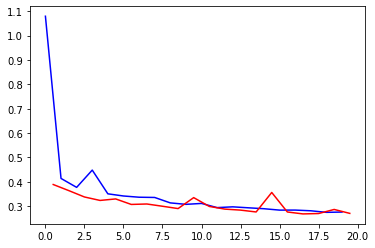

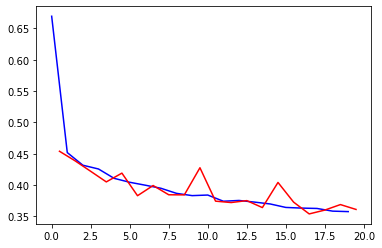

129/129 [==============================] - 0s 2ms/step - loss: 0.3469 - mean_squared_error: 0.3469 - mean_absolute_error: 0.3817
R2 model evaluation 0.6009421487866355


In [13]:
#Fit functional model
mcp=tf.keras.callbacks.ModelCheckpoint("best_functional_model_1.h5",monitor="mean_squared_error",verbose=1,save_best_only=True)

wd_model1=functional_model_1(units=256,dropout=0.1)
history=wd_model1.fit(X_train,y_train,batch_size=BATCH,epochs=EPOCHS,validation_split=VAL_SPLIT,callbacks=[callbacks,mcp])
epochs=history.epoch
history=history.history

print("Best epoch", np.argmin(history['val_loss']))
model_eval(history,epochs)

#Get the best model

best_functional_model_1=tf.keras.models.load_model("best_functional_model_1.h5")

#Evaluate model
best_functional_model_1.evaluate(X_test,y_test)

y_pred=best_functional_model_1.predict(X_test)

print("R2 model evaluation",r2_score(y_test,y_pred))

In [14]:
#Develop functional model where feature modelling is split

def functional_model_2(features_A,features_B,units=32, dropout=0.2,input_shape=INPUT_SHAPE):
  """
  A simple functional model builder with wide and deep elements
  #Arguments
  units, int - dense layer units
  input_shape, tuple(int) - input shape (None, Features)
  features_A, int - the number of features for wide input
  features_B, int - the number of featurs for deep input
  #Returns
  model (keras obj)
  """

  #NOTE feature number checks should be implemneted for further model testing

  input_A=tf.keras.layers.Input(shape=[features_A],name="wide_input")
  input_B=tf.keras.layers.Input(shape=[features_B],name="deep_input")

  #Deep architecture
  hidden1=tf.keras.layers.Dense(units*4,activation='relu')(input_B)
  dropout_h1=tf.keras.layers.Dropout(dropout)(hidden1)
  hidden2=tf.keras.layers.Dense(units*2,activation='relu')(dropout_h1)
  dropout_h2=tf.keras.layers.Dropout(dropout)(hidden2)
  hidden3=tf.keras.layers.Dense(units*2,activation='relu')(dropout_h1)
  dropout_h3=tf.keras.layers.Dropout(dropout)(hidden3)
  hidden4=tf.keras.layers.Dense(units,activation='relu')(dropout_h3)
  dropout_h4=tf.keras.layers.Dropout(dropout)(hidden4)

  hidden5=None
  #Combine deep and wide architectures
  if units//2 >10:
    hidden5=tf.keras.layers.Dense(units,activation='relu')(dropout_h4)
  
  if hidden5 is not None:
    concat=tf.keras.layers.Concatenate()([input_A,hidden5])
  else:
    concat=tf.keras.layers.Concatenate()([input_A,dropout_h4])

  
  output=keras.layers.Dense(1,name="output")(concat)

  
  model=tf.keras.Model(inputs=[input_A,input_B],outputs=[output])

  print(model.summary())

  model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mean_squared_error','mean_absolute_error'])

  return model






In [15]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [16]:
#Split features
#The example considers even feature split
X_train_A,X_train_B=X_train[:,:4], X_train[:,4:]
X_test_A,X_test_B=X_test[:,:4], X_test[:,4:]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 deep_input (InputLayer)        [(None, 4)]          0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 512)          2560        ['deep_input[0][0]']             
                                                                                                  
 dropout_1 (Dropout)            (None, 512)          0           ['dense_4[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 256)          131328      ['dropout_1[0][0]']              
                                                                                            

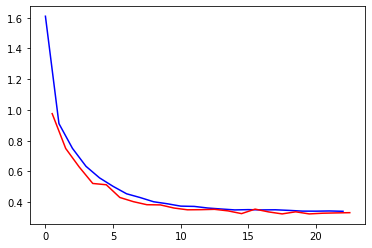

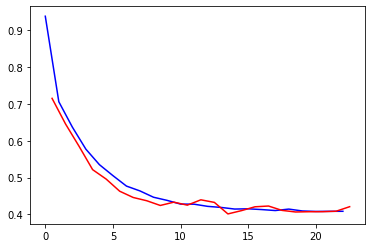

129/129 [==============================] - 0s 2ms/step - loss: 0.3399 - mean_squared_error: 0.3399 - mean_absolute_error: 0.4209
R2 model evaluation 0.681612530794778


In [17]:
#Fit functional model
mcp=tf.keras.callbacks.ModelCheckpoint("best_wide_and_deel_model_2.h5",monitor="mean_squared_error",verbose=1,save_best_only=True)

wd_model2=functional_model_2(4,4,units=128,dropout=0.1)
history=wd_model2.fit((X_train_A,X_train_B),y_train,batch_size=BATCH,epochs=EPOCHS,validation_split=VAL_SPLIT,callbacks=[callbacks,mcp])
epochs=history.epoch
history=history.history

print("Best epoch", np.argmin(history['val_loss']))
model_eval(history,epochs)

#Get the best model

best_wd_model2=tf.keras.models.load_model("best_wide_and_deel_model_2.h5")

#Evaluate model
best_wd_model2.evaluate((X_test_A,X_test_B),y_test)

y_pred=best_wd_model2.predict((X_test_A,X_test_B))

print("R2 model evaluation",r2_score(y_test,y_pred))

Conv1D layers are typically used for NLP and sequential process analyses. However, it is interesting to explore if specific features for housing have dependencies that might be explored.

Assessing model performance and behaviour can give valuable insights about the data and this information can be then used to fine tune target models.

In [80]:
#Develop functional model where feature modelling is split

def functional_model_3(features_A,features_B,units=32, dropout=0.2,input_shape=INPUT_SHAPE):
  """
  A simple functional model builder with wide and deep elements
  #Arguments
  units, int - dense layer units
  input_shape, tuple(int) - input shape (None, Features)
  features_A, int - the number of features for wide input
  features_B, int - the number of featurs for deep input
  #Returns
  model (keras obj)
  """

  #NOTE feature number checks should be implemneted for further model testing

  input_A=tf.keras.layers.Input(shape=(features_A,1),name="wide_conv_input")
  
  input_B=tf.keras.layers.Input(shape=(features_B),name="deep_input")

  #Deep architecture
  hidden1_B=tf.keras.layers.Dense(units*4,activation='relu')(input_B)
  dropout_h1_B=tf.keras.layers.Dropout(dropout)(hidden1_B)
  hidden2_B=tf.keras.layers.Dense(units*2,activation='relu')(dropout_h1_B)
  dropout_h2_B=tf.keras.layers.Dropout(dropout)(hidden2_B)
  hidden3_B=tf.keras.layers.Dense(units*2,activation='relu')(dropout_h2_B)
  dropout_h3_B=tf.keras.layers.Dropout(dropout)(hidden3_B)
  hidden4_B=tf.keras.layers.Dense(units,activation='relu')(dropout_h3_B)
  dropout_h4_B=tf.keras.layers.Dropout(dropout)(hidden4_B)

  hidden5_B=None
  if units//2 >10:
    hidden5_B=tf.keras.layers.Dense(units,activation='relu')(dropout_h4_B)

  #Wide-deep architecture
  hidden1_A=tf.keras.layers.Conv1D(512,3,activation='relu',padding='same')(input_A)
  
  maxpool_1_A=tf.keras.layers.MaxPooling1D(2)(hidden1_A)
  hidden2_A=tf.keras.layers.Conv1D(128,3,activation='relu',padding='same')(maxpool_1_A)
  maxpool_2_A=tf.keras.layers.MaxPooling1D(2)(hidden2_A)
  hidden3_A=tf.keras.layers.Conv1D(64,3,activation='relu',padding='same')(maxpool_2_A)
  globave_4_A=tf.keras.layers.GlobalAveragePooling1D()(hidden3_A)
  hdden4_A=tf.keras.layers.Dense(64,activation='relu')(globave_4_A)
  dropout_4_A=tf.keras.layers.Dropout(dropout/2)(hdden4_A)
  hdden5_A=tf.keras.layers.Dense(32,activation='relu')(dropout_4_A)



  
   #Combine deep and wide architectures
  if hidden5_B is not None:
    concat=tf.keras.layers.Concatenate()([hdden5_A,hidden5_B])
  else:
    concat=tf.keras.layers.Concatenate()([hdden5_A,dropout_h4_B])

  
  output=keras.layers.Dense(1,name="output")(concat)

  
  model=tf.keras.Model(inputs=[input_A,input_B],outputs=[output])

  print(model.summary())

  model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mean_squared_error','mean_absolute_error'])

  return model






Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 wide_conv_input (InputLayer)   [(None, 4, 1)]       0           []                               
                                                                                                  
 deep_input (InputLayer)        [(None, 4)]          0           []                               
                                                                                                  
 conv1d_86 (Conv1D)             (None, 4, 512)       2048        ['wide_conv_input[0][0]']        
                                                                                                  
 dense_175 (Dense)              (None, 512)          2560        ['deep_input[0][0]']             
                                                                                           

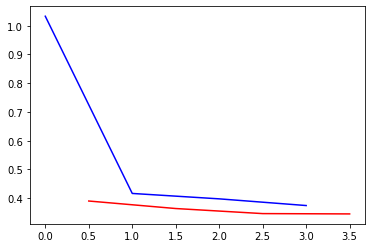

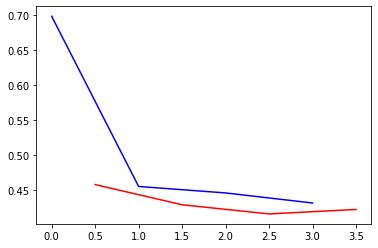

129/129 [==============================] - 1s 3ms/step - loss: 0.3645 - mean_squared_error: 0.3645 - mean_absolute_error: 0.4254
R2 model evaluation 0.6415663310677049


In [81]:
#Fit functional model
mcp=tf.keras.callbacks.ModelCheckpoint("best_wide_and_deel_model_3.h5",monitor="mean_squared_error",verbose=1,save_best_only=True)

wd_model3=functional_model_3(4,4,units=128,dropout=0.1)
history=wd_model3.fit((X_train_A,X_train_B),y_train,batch_size=BATCH,epochs=EPOCHS,validation_split=VAL_SPLIT,callbacks=[callbacks,mcp])
epochs=history.epoch
history=history.history

print("Best epoch", np.argmin(history['val_loss']))
model_eval(history,epochs)

#Get the best model

best_wd_model3=tf.keras.models.load_model("best_wide_and_deel_model_3.h5")

#Evaluate model
best_wd_model3.evaluate((X_test_A,X_test_B),y_test)

y_pred=best_wd_model3.predict((X_test_A,X_test_B))

print("R2 model evaluation",r2_score(y_test,y_pred))